In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

In [13]:
from scipy.ndimage import gaussian_filter


def _rescale_to_unit_square(pts: np.ndarray, eps: float = 1e-8) -> np.ndarray:
    mins = pts.min(axis=0)
    maxs = pts.max(axis=0)
    spans = maxs - mins
    spans[spans < eps] = 1.0
    return (pts - mins) / spans


def _points_to_image(points: np.ndarray, grid_size: int = 64, sigma: float = 1.0) -> np.ndarray:
    img = np.zeros((grid_size, grid_size), dtype=np.float32)
    indices = (points * (grid_size - 1)).astype(int)
    indices = np.clip(indices, 0, grid_size - 1)
    xs = indices[:, 0]
    ys = indices[:, 1]
    np.add.at(img, (ys, xs), 1.0)
    if sigma is not None and sigma > 0:
        img = gaussian_filter(img, sigma=sigma)
    s = img.max()
    if s > 0:
        img = img / s
    return img

In [21]:
def gen_two_slit_point_samples(
    n_points: int,
    slit_width: float,
    slit_sep: float,
    L: float,
    wavelength: float,
    extent: float = 0.8,
    nr: int = 2000
) -> np.ndarray:
    coord = np.linspace(-0.5 * extent, 0.5 * extent, nr)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        arg_sinc = np.pi * slit_width * coord / (wavelength * L + 1e-12)
        envelope = (np.sinc(arg_sinc / np.pi)) ** 2
        arg_cos = np.pi * slit_sep * coord / (wavelength * L + 1e-12)
        interference = np.cos(arg_cos) ** 2
        I = envelope * interference
        
    if I.max() <= 0:
        I = np.ones_like(I)
        
    pdf = I / I.sum()
    cdf = np.cumsum(pdf)
    u = np.random.rand(n_points)
    sampled_coord = np.interp(u, cdf, coord)
    along = np.random.uniform(0.0, 1.0, size=n_points)
    xs = sampled_coord
    ys = along * extent - 0.5 * extent
    pts = np.column_stack([xs, ys])
    pts = _rescale_to_unit_square(pts)
    
    return pts


def gen_two_slit_continuous_image(
    grid_size: int,
    slit_width: float,
    slit_sep: float,
    L: float,
    wavelength: float,
    extent: float = 0.8,
    vertical_smooth: float = 0.6
) -> np.ndarray:
    x = np.linspace(-0.5 * extent, 0.5 * extent, grid_size)
    denom = (wavelength * L + 1e-12)
    env = np.sinc((slit_width * x) / denom) ** 2
    interfer = np.cos(np.pi * slit_sep * x / denom) ** 2
    I = env * interfer
    
    if I.max() > 0:
        I = I / I.max()
        
    img = np.tile(I[np.newaxis, :], (grid_size, 1))
    
    if vertical_smooth is not None and vertical_smooth > 0:
        img = gaussian_filter(img, sigma=(vertical_smooth, 0.0))
    s = img.max()
    
    if s > 0:
        img = img / s
        
    return img.astype(np.float32)

In [23]:
n_samples = 1000
grid_size = 64
X_points = np.zeros((n_samples, grid_size, grid_size), dtype=np.float32)
X_cont  = np.zeros((n_samples, grid_size, grid_size), dtype=np.float32)
params = []

wavelength_min, wavelength_max = 0.005, 0.04
a_min, a_max = 0.01, 0.12
d_min, d_max = 0.05, 0.5
L_min, L_max = 0.6, 2.5

for i in range(n_samples):
    slit_width = float(np.random.uniform(a_min, a_max))
    slit_sep = float(np.random.uniform(d_min, d_max))
    L = float(np.random.uniform(L_min, L_max))
    wavelength = float(np.random.uniform(wavelength_min, wavelength_max))
    n_points = int(np.random.randint(500, 1200))
    pts = gen_two_slit_point_samples(
        n_points=n_points,
        slit_width=slit_width,
        slit_sep=slit_sep,
        L=L,
        wavelength=wavelength,
        extent=0.9
    )
    pts = np.clip(pts, 0.0, 1.0)
    img_points = _points_to_image(pts, grid_size=grid_size, sigma=0.8)
    
    img_cont = gen_two_slit_continuous_image(
        grid_size=grid_size,
        slit_width=slit_width,
        slit_sep=slit_sep,
        L=L,
        wavelength=wavelength,
        extent=0.9,
        vertical_smooth=0.6
    )
    X_points[i] = img_points
    X_cont[i] = img_cont
    params.append((slit_width, slit_sep, L, wavelength))

np.savez_compressed("diffraction_point_and_continuous.npz", X_points=X_points, X_cont=X_cont, params=np.array(params))
print("Saved dataset with shapes", X_points.shape, X_cont.shape)


Saved dataset with shapes (1000, 64, 64) (1000, 64, 64)


In [25]:
from sklearn.model_selection import train_test_split

data = np.load("diffraction_point_and_continuous.npz", allow_pickle=True)
X_points = data["X_points"].astype(np.float32)
X_cont = data["X_cont"].astype(np.float32)
params = data["params"]
X_points = X_points[..., np.newaxis]
X_cont = X_cont[..., np.newaxis]
X_p_train, X_p_val, X_c_train, X_c_val = train_test_split(X_points, X_cont, test_size=0.15, random_state=42, shuffle=True)
print("Train / val shapes (points -> cont):", X_p_train.shape, X_p_val.shape)


Train / val shapes (points -> cont): (850, 64, 64, 1) (150, 64, 64, 1)


In [27]:
from keras import layers, models, optimizers


def build_image_autoencoder(input_shape: tuple, latent_dim: int = 64) -> tuple[models.Model, models.Model, models.Model]:
    inp = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, strides=1, padding="same", activation="relu")(inp)
    x = layers.MaxPool2D(2)(x)
    x = layers.Conv2D(64, 3, strides=1, padding="same", activation="relu")(x)
    x = layers.MaxPool2D(2)(x)
    x = layers.Conv2D(128, 3, strides=1, padding="same", activation="relu")(x)
    x = layers.MaxPool2D(2)(x)
    shape_before_flat = x.shape[1:]
    x = layers.Flatten()(x)
    z = layers.Dense(latent_dim, name="latent")(x)
    encoder = models.Model(inp, z, name="encoder")
    
    latent_input = layers.Input(shape=(latent_dim,))
    x = layers.Dense(int(np.prod(shape_before_flat)))(latent_input)
    x = layers.Reshape(shape_before_flat)(x)
    x = layers.Conv2DTranspose(128, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
    out = layers.Conv2D(input_shape[-1], 3, padding="same", activation="sigmoid")(x)
    decoder = models.Model(latent_input, out, name="decoder")
    
    reconstructed = decoder(encoder(inp))
    auto = models.Model(inp, reconstructed, name="autoencoder")
    auto.compile(optimizer=optimizers.Adam(learning_rate=1e-3), loss="mse", metrics=["mse"])
    return auto, encoder, decoder


auto, encoder, decoder = build_image_autoencoder(X_p_train.shape[1:], latent_dim=64)
history = auto.fit(
    X_p_train,
    X_c_train,
    validation_data=(X_p_val, X_c_val),
    epochs=30,
    batch_size=32,
    verbose=2
)
auto.save("point2cont_autoencoder.keras")
encoder.save("point2cont_encoder.keras")
decoder.save("point2cont_decoder.keras")


Epoch 1/30
27/27 - 11s - 417ms/step - loss: 0.1237 - mse: 0.1237 - val_loss: 0.0825 - val_mse: 0.0825
Epoch 2/30
27/27 - 6s - 213ms/step - loss: 0.0633 - mse: 0.0633 - val_loss: 0.0582 - val_mse: 0.0582
Epoch 3/30
27/27 - 6s - 212ms/step - loss: 0.0532 - mse: 0.0532 - val_loss: 0.0538 - val_mse: 0.0538
Epoch 4/30
27/27 - 6s - 222ms/step - loss: 0.0512 - mse: 0.0512 - val_loss: 0.0528 - val_mse: 0.0528
Epoch 5/30
27/27 - 6s - 238ms/step - loss: 0.0499 - mse: 0.0499 - val_loss: 0.0513 - val_mse: 0.0513
Epoch 6/30
27/27 - 6s - 208ms/step - loss: 0.0462 - mse: 0.0462 - val_loss: 0.0441 - val_mse: 0.0441
Epoch 7/30
27/27 - 6s - 216ms/step - loss: 0.0381 - mse: 0.0381 - val_loss: 0.0355 - val_mse: 0.0355
Epoch 8/30
27/27 - 6s - 216ms/step - loss: 0.0328 - mse: 0.0328 - val_loss: 0.0311 - val_mse: 0.0311
Epoch 9/30
27/27 - 6s - 218ms/step - loss: 0.0286 - mse: 0.0286 - val_loss: 0.0294 - val_mse: 0.0294
Epoch 10/30
27/27 - 6s - 221ms/step - loss: 0.0258 - mse: 0.0258 - val_loss: 0.0278 - val_

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
VAL mean MSE (point->cont): 1.490512e-02


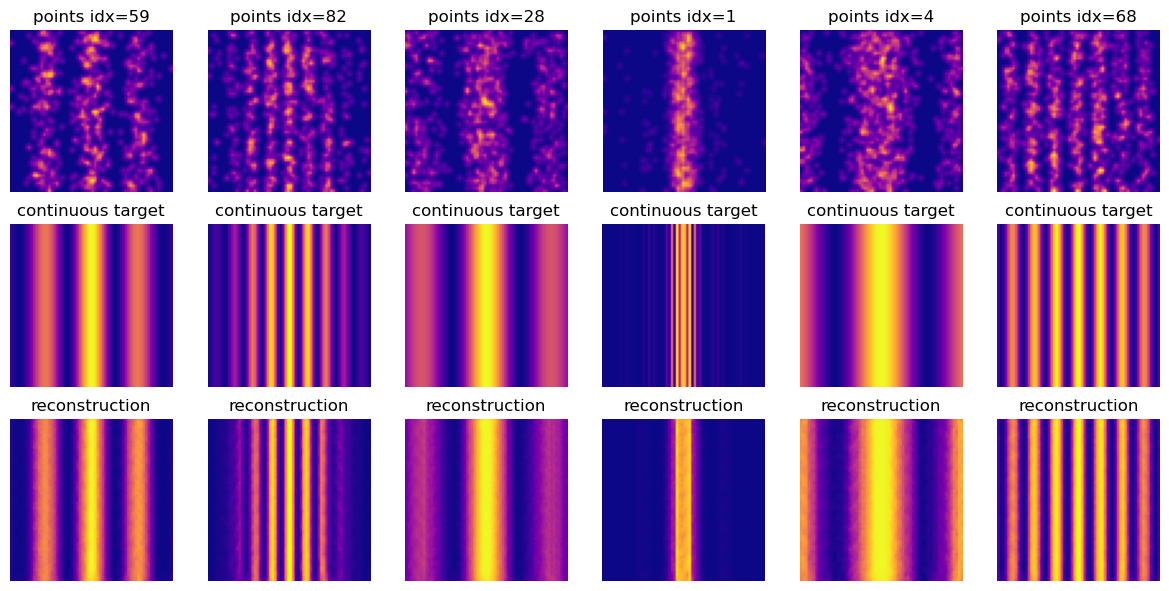

In [35]:
X_rec = auto.predict(X_p_val, batch_size=64)
mse_per_sample = np.mean((X_c_val - X_rec) ** 2, axis=(1, 2, 3))
print(f"VAL mean MSE (point->cont): {mse_per_sample.mean():.6e}")

n_show = 6
idxs = np.random.choice(len(X_p_val), n_show, replace=False)
plt.figure(figsize=(2 * n_show, 6))

for i, idx in enumerate(idxs):
    plt.subplot(3, n_show, i + 1)
    plt.imshow(X_p_val[idx].squeeze(), origin="lower", cmap="plasma")
    plt.title(f"points idx={idx}")
    plt.axis("off")
    plt.subplot(3, n_show, n_show + i + 1)
    plt.imshow(X_c_val[idx].squeeze(), origin="lower", cmap="plasma")
    plt.title("continuous target")
    plt.axis("off")
    plt.subplot(3, n_show, 2 * n_show + i + 1)
    plt.imshow(X_rec[idx].squeeze(), origin="lower", cmap="plasma")
    plt.title("reconstruction")
    plt.axis("off")
    
plt.tight_layout()
plt.savefig('slit-diffraction.png')
plt.show()